## Pneumonia

### Step 1. 실험환경 Set-up
- 거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

In [1]:
import os, re # 정규표현식 관련된 작업에 필요한 패키지
import random, math
import numpy as np # 데이터 array 작업에 필요한 패키지
import tensorflow as tf # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt   # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split # 데이터 전처리에 필요한 패키지

In [2]:
# 필요한 변수 생성

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# BATCH_SIZE 변수
BATCH_SIZE = 20

# EPOCH 크기 변수
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


### Step 2. 데이터 준비하기
- 원본 데이터를 가져와서 전처리 및 배치 구성을 진행

In [3]:
# 각 데이터 개수 체크하기

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print('train 안에는 {}개가 있습이다.'.format(len(train_filenames)))
print('test 안에는 {}개가 있습이다.'.format(len(test_filenames)))
print('val 안에는 {}개가 있습이다.'.format(len(val_filenames)))      


train 안에는 5216개가 있습이다.
test 안에는 624개가 있습이다.
val 안에는 16개가 있습이다.


##### validation 값 보충을 위해 train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다

filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('train 안에는 {}개가 있습이다.'.format(len(train_filenames)))
print('val 안에는 {}개가 있습이다.'.format(len(val_filenames))) 

train 안에는 4185개가 있습이다.
val 안에는 1047개가 있습이다.


In [5]:
# train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 확인

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0614-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1346_bacteria_3430.jpeg


In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [7]:
# tf.data 인스턴스를 만들기( tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있음)

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# Train 데이터셋, validation 데이터셋 개수 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 라벨 데이터 생성

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지 사이즈 축소

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
# train 데이터 셋과 validation 데이터 셋 만들기

# set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지 리사이즈 및 라벨 재확인

for image, label in train_ds.take(1): # train_ds.take(1) =1개의 데이터만 갖고 온다.
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
# test 데이터 셋 만들기, 개수 확인

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

- prepare_for_training() 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환
- shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
- repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용 가능(자동으로 데이터에 맞춰줌)
- batch()를 사용시 BATCH_SIZE에서 정한 만큼 배치
- prefetch()를 사용시 학습 데이터 나눠서 읽어오는 기능 (1번째 데이터  GPU 학습시 두번째  CPU 준비

## Step 3. 데이터 시각화

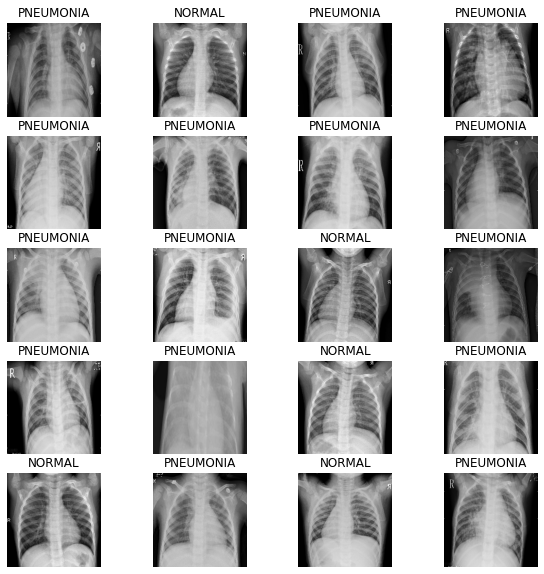

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())    #show_batch 결과 사진 확인

## Step 4. CNN 모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

- cnn : http://taewan.kim/post/cnn/
- conv_block()의 구성 : Convolution을 2번 진행 > Batch Normalization>Gradient vanishing, Gradient Exploding 해결> Max Pooling

In [17]:
# Danse_block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

-  Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용 *일반적으로 미사용, 금기시

In [18]:
# Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


- imbalance : 한 라벨이 너무 많은 경우, 데이터 학습시 학습효과 좋지 않음.*Weight balancing 으로 해결

Weight balancing 
- training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여

## Step 6. 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy', #정확도
        tf.keras.metrics.Precision(name='precision'), #정밀도
        tf.keras.metrics.Recall(name='recall') #회상
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
209/209 [==============================] - 58s 167ms/step - loss: 0.4956 - accuracy: 0.7374 - precision: 0.9255 - recall: 0.6981 - val_loss: 0.6819 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
209/209 [==============================] - 33s 160ms/step - loss: 0.2637 - accuracy: 0.9022 - precision: 0.9660 - recall: 0.9015 - val_loss: 1.1517 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/10
209/209 [==============================] - 34s 161ms/step - loss: 0.1931 - accuracy: 0.9234 - precision: 0.9740 - recall: 0.9211 - val_loss: 1.3989 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 4/10
209/209 [==============================] - 33s 160ms/step - loss: 0.1698 - accuracy: 0.9363 - precision: 0.9777 - recall: 0.9365 - val_loss: 0.1441 - val_accuracy: 0.9452 - val_precision: 0.9338 - val_recall: 0.9961
Epoch 5/10
209/209 [==============================] - 33s 160ms/step - loss: 0.1958 - accura

## Step 7. 결과 확인과 시각화

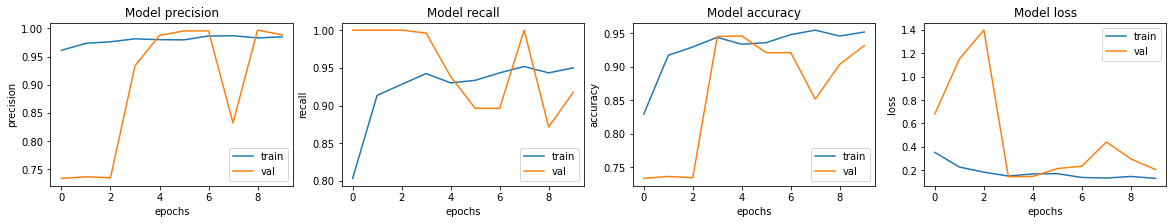

In [22]:
# loss 변화 
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
#test 데이터 모델평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

32/32 [==============================] - 10s 324ms/step - loss: 0.5669 - accuracy: 0.8590 - precision: 0.8416 - recall: 0.9538
Loss: 0.5669320821762085,
Accuracy: 0.8589743375778198,
Precision: 0.8416289687156677,
Recall: 0.9538461565971375


## 평가

1. 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.
2. regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.
3. Accuracy 기준 85%에 도달하였다.

## 회고
1. 낯선 용어와 함수들로 이해가 잘 되지 않아 어려웠고, 일부 폐렴 사진도 정상폐와 잘 구분이 되지 않았다. 전문가의 식견이 필요한듯.. 
   그래도 일부사진에서는 폐렴을 인지했으므로 내가 병원가서 폐렴 ct찍었을때 유심히 볼것 같다.
   
2. Accuracy 기준 85%에 도달이 4시간 시도 끝에 완료 되었는데,  같은 BATCH_SIZ, epochs에도 정확도가 달라지기도 하였다.
- BATCH_SIZE = 20 공통 /  epochs 17 = 78%, epochs 19 = 77%~82%   epochs 20 = 82%~87%,  epochs 21 = 70~76%, epochs 25 = 67% 
- BATCH_SIZE = 15 공통 /  epochs 20 = 83%  epochs 18 = 83%       epochs 10 = 87%       epochs 7  = 83%  epochs  6= 86%,  epochs  5 = 86%  
- BATCH_SIZE = 17 epochs  25 = 76%
- BATCH_SIZE = 18 epochs  18 = 76%
- BATCH_SIZE = 21 epochs 20 = 73%

- 최종 BATCH_SIZE = 20 epochs 10 = 85% 